In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats, sigma_clip

%matplotlib inline

file_path = {'NUV': '../ngc1087/hlsp_phangs-hst_hst_wfc3-uvis_ngc1087_f275w_v1_exp-drc-sci.fits', 'U': '../ngc1087/hlsp_phangs-hst_hst_wfc3-uvis_ngc1087_f336w_v1_exp-drc-sci.fits' , 'B': '../ngc1087/hlsp_phangs-hst_hst_wfc3-uvis_ngc1087_f438w_v1_exp-drc-sci.fits' ,'V':'../ngc1087/hlsp_phangs-hst_hst_wfc3-uvis_ngc1087_f555w_v1_exp-drc-sci.fits', 'I': '../ngc1087/hlsp_phangs-hst_hst_wfc3-uvis_ngc1087_f814w_v1_exp-drc-sci.fits'}

wavelength = {'NUV': 275, 'U': 336, 'B': 438, 'V':555, 'I': 814}

In [2]:
img=fits.open(file_path['U'])
img_details= img[0].header
img.close()

In [3]:
ra_img_centre, dec_img_centre = img_details['CRVAL1'], img_details['CRVAL2']

from astropy.wcs import WCS

# conversion from ra-dec to pixel
def radec_to_pixel(equi, img_details=img_details):
    w = WCS(img_details)
    # ra, dec = equi
    x, y = w.all_world2pix([equi], 1)[0]  # Using origin=1 for FITS standard
    return [x, y]

In [4]:
catalog_data=Table.read('../ngc1087/catalogs/hlsp_phangs-cat_hst_uvis_ngc1087_multi_v1_obs-human-cluster-class12.fits')

cluster_equi_coord = np.array([catalog_data['PHANGS_RA'], catalog_data['PHANGS_DEC']]).T
cluster_pixels = [radec_to_pixel(equi_coord) for equi_coord in cluster_equi_coord]

app_mag_PHANGS={'NUV': catalog_data['PHANGS_F275W_VEGA'], 'U': catalog_data['PHANGS_F336W_VEGA'], 'B': catalog_data['PHANGS_F438W_VEGA'], 'V': catalog_data['PHANGS_F555W_VEGA'], 'I': catalog_data['PHANGS_F814W_VEGA']}

In [5]:
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry, ApertureStats

In [6]:
invSensitivity={}

mAB_to_Vega={'NUV': 1.4, 'U': 1.158, 'B': -0.178, 'V': -0.048, 'I': 0.395} # Vega magnitude to be subtracted from the AB magnitude above for different bands
extinction_factor={'NUV': 0.187, 'U': 0.152, 'B': 0.124, 'V':0.0957, 'I': 0.0509}
aperture_corr={'NUV': -0.86, 'U': -0.79, 'B': -0.70, 'V':-0.67, 'I': -0.79}

In [7]:
aperture=CircularAperture(cluster_pixels, r=4)
annulus_aperture = CircularAnnulus(cluster_pixels, r_in=7, r_out=8)

phot_table={}
coefficients={}

for key in file_path:
    img=fits.open(file_path[key])
    img_data = ma.masked_equal(img[0].data, 0)
    
    invSensitivity[key]=img[0].header['PHOTFNU'] # Inverse sensitivity in Jy*sec/e-
    
    phot_table[key] = aperture_photometry(img_data, aperture)
    
    aperstats = ApertureStats(img_data, annulus_aperture)
    bkg_mean = aperstats.mean
    aperture_area = aperture.area_overlap(img_data)
    
    phot_table[key]['aperture_sum_bkgsub'] = phot_table[key]['aperture_sum'] - bkg_mean * aperture_area

    phot_table[key]['app_mag_PHANGS']=app_mag_PHANGS[key]
    
    mask = phot_table[key]['aperture_sum_bkgsub'] > 0
    phot_table[key] = phot_table[key][mask]    
    
    phot_table[key]['uncorrected_AB_mag']=-2.5*np.log10(phot_table[key]['aperture_sum_bkgsub']*invSensitivity[key])+8.9
    phot_table[key]['corrected_app_mag']=phot_table[key]['uncorrected_AB_mag']-mAB_to_Vega[key]+aperture_corr[key]-extinction_factor[key]
    
    coefficients[key] = np.polyfit(phot_table[key]['corrected_app_mag'], phot_table[key]['app_mag_PHANGS'], 1)

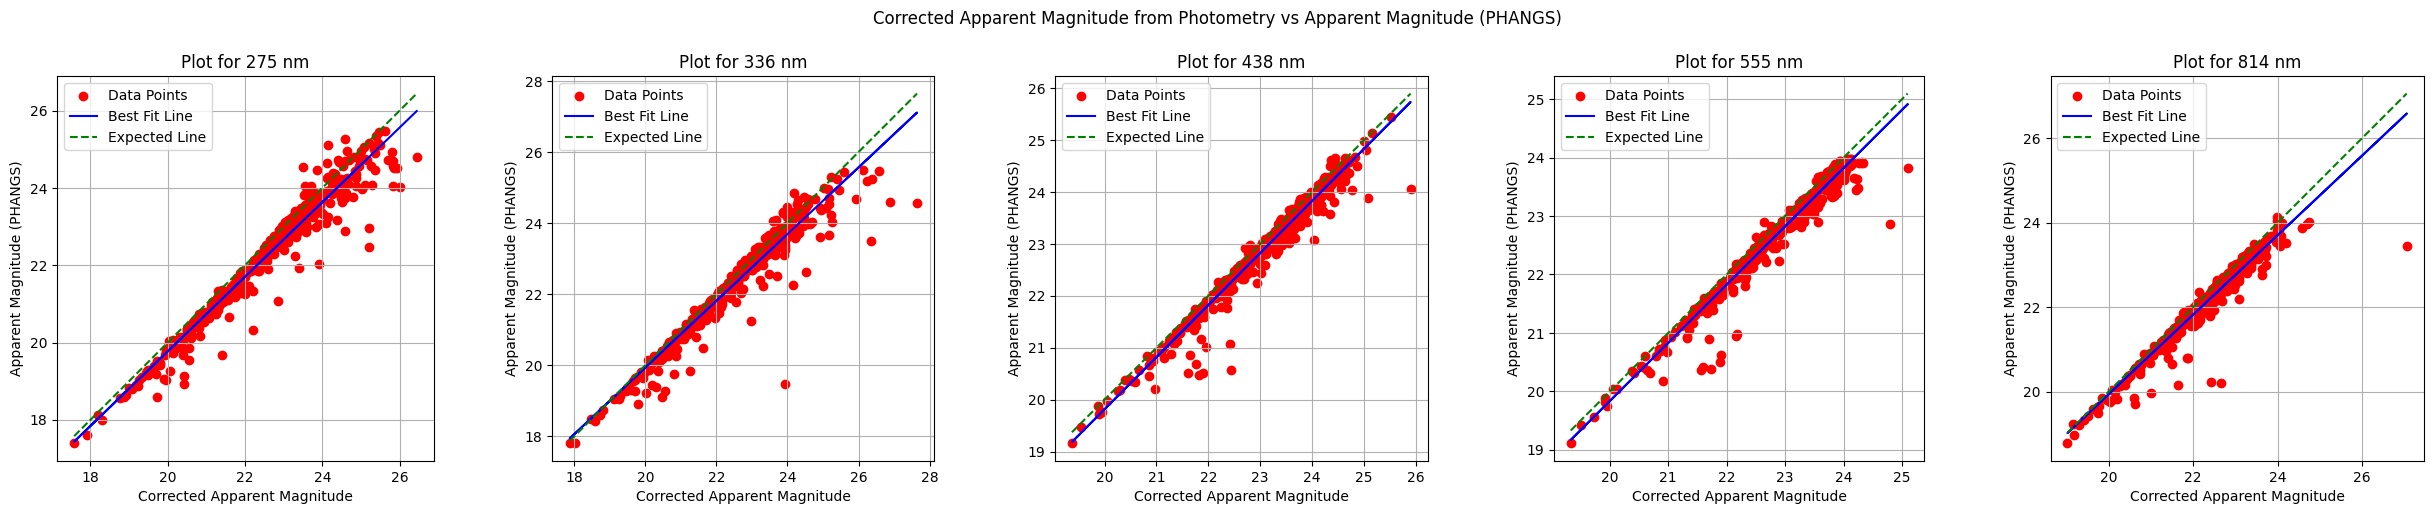

In [8]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle('Corrected Apparent Magnitude from Photometry vs Apparent Magnitude (PHANGS)')

keys = list(phot_table.keys())[:5]

for i, key in enumerate(keys):
    axs[i].scatter(phot_table[key]['corrected_app_mag'], phot_table[key]['app_mag_PHANGS'], color='red', label='Data Points')
    axs[i].plot(phot_table[key]['corrected_app_mag'], np.polyval(coefficients[key], phot_table[key]['corrected_app_mag']), 'b-', label='Best Fit Line')
    
    minval, maxval = min(phot_table[key]['corrected_app_mag']), max(phot_table[key]['corrected_app_mag'])
    
    axs[i].plot([minval,maxval],[minval,maxval],linestyle='dashed', color='green', label='Expected Line')
    axs[i].set_title(f'Plot for {wavelength[key]} nm')
    axs[i].set_xlabel('Corrected Apparent Magnitude')
    axs[i].set_ylabel('Apparent Magnitude (PHANGS)')
    axs[i].grid(True)
    axs[i].legend()
    axs[i].set_aspect('equal', 'box')

plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('Comp_Mag_corrected_all_bands.png')
plt.show()